In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score, mean_squared_error
import joblib
import ast  # For converting string dictionaries to real dictionaries
from google.colab import files
import io
import matplotlib.pyplot as plt # Import matplotlib

In [3]:
# Step 1: Upload the data
print("Upload Pseudomonas aeruginosa protein dataset:")
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

Upload Pseudomonas aeruginosa protein dataset:


Saving Pseudomonas aeruginosa Protein.csv to Pseudomonas aeruginosa Protein.csv


In [4]:
# Convert dictionary strings to actual dictionaries
df['Amino_Acid_Composition'] = df['Amino_Acid_Composition'].apply(ast.literal_eval)

# Create comprehensive amino acid features
amino_acids = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
for aa in amino_acids:
    df[f'{aa}_count'] = df['Amino_Acid_Composition'].apply(lambda x: x.get(aa, 0))
    df[f'{aa}_percent'] = df[f'{aa}_count'] / df['Seq_Length']

# Calculate physicochemical properties
df['Charge_Density'] = (df['R_count'] + df['K_count'] - df['D_count'] - df['E_count']) / df['Seq_Length']
df['Hydrophobic_Ratio'] = (df['A_count'] + df['V_count'] + df['L_count'] + df['I_count']) / df['Seq_Length']


In [7]:
def detect_target_type(series):
    unique_values = series.nunique()
    if unique_values < 10 or series.dtype == 'object':
        return 'classification'
    else:
        return 'regression'

target_columns = ['Hydrophobicity', 'Isoelectric_Point', 'Molecular_Weight', 'Protein_Length']
target_info = {col: detect_target_type(df[col]) for col in target_columns}

print("\nDetected Target Types:")
for target, t_type in target_info.items():
    print(f"{target}: {t_type}")

# 4. Multi-Target Modeling Pipeline
results = {}

for target, t_type in target_info.items():
    print(f"\n=== Modeling for {target} ({t_type}) ===")

    # Prepare data
    features = [col for col in df.columns if col not in [
        'ID', 'Name', 'Sequence', 'Amino_Acid_Composition',
        'Molecular_Weight', 'MW_Calc', 'Protein_Length', target
    ] and df[col].dtype in ['float64', 'int64']]

    X = df[features]
    y = df[target]

    # Special handling for classification
    if t_type == 'classification':
        if y.dtype == 'object':
            le = LabelEncoder()
            y = le.fit_transform(y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model selection
    if t_type == 'classification':
        models = {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
        }
    else:
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
        }

    # Train and evaluate
    target_results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        if t_type == 'classification':
            accuracy = accuracy_score(y_test, y_pred)
            print(f"\n{name} Accuracy: {accuracy:.4f}")
            print(classification_report(y_test, y_pred))
            target_results[name] = {'accuracy': accuracy}
        else:
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            print(f"\n{name} Performance:")
            print(f"R²: {r2:.4f}")
            print(f"MSE: {mse:.4f}")
            target_results[name] = {'r2': r2, 'mse': mse}

    # Save best model
    if t_type == 'classification':
        best_model_name = max(target_results.items(), key=lambda x: x[1]['accuracy'])[0]
    else:
        best_model_name = max(target_results.items(), key=lambda x: x[1]['r2'])[0]

    best_model = models[best_model_name]
    joblib.dump(best_model, f'best_model_{target}.pkl')
    joblib.dump(scaler, f'scaler_{target}.pkl')
    print(f"\nSaved best model for {target}: {best_model_name}")

    results[target] = {
        'type': t_type,
        'best_model': best_model_name,
        'performance': target_results[best_model_name],
        'features': features
    }


Detected Target Types:
Hydrophobicity: regression
Isoelectric_Point: regression
Molecular_Weight: regression
Protein_Length: regression

=== Modeling for Hydrophobicity (regression) ===

Linear Regression Performance:
R²: 0.4829
MSE: 0.0021

Random Forest Performance:
R²: 0.6357
MSE: 0.0015

Saved best model for Hydrophobicity: Random Forest

=== Modeling for Isoelectric_Point (regression) ===

Linear Regression Performance:
R²: 0.8697
MSE: 0.4383

Random Forest Performance:
R²: 0.9894
MSE: 0.0357

Saved best model for Isoelectric_Point: Random Forest

=== Modeling for Molecular_Weight (regression) ===

Linear Regression Performance:
R²: 0.9759
MSE: 26706846.8770

Random Forest Performance:
R²: 0.9991
MSE: 995886.2272

Saved best model for Molecular_Weight: Random Forest

=== Modeling for Protein_Length (regression) ===

Linear Regression Performance:
R²: 0.9736
MSE: 2338.3598

Random Forest Performance:
R²: 0.9998
MSE: 14.8734

Saved best model for Protein_Length: Random Forest



 Example Predictions

Predicted Hydrophobicity: 0.0846

Predicted Isoelectric_Point: 4.7999

Predicted Molecular_Weight: 27592.3173

Predicted Protein_Length: 249.7200


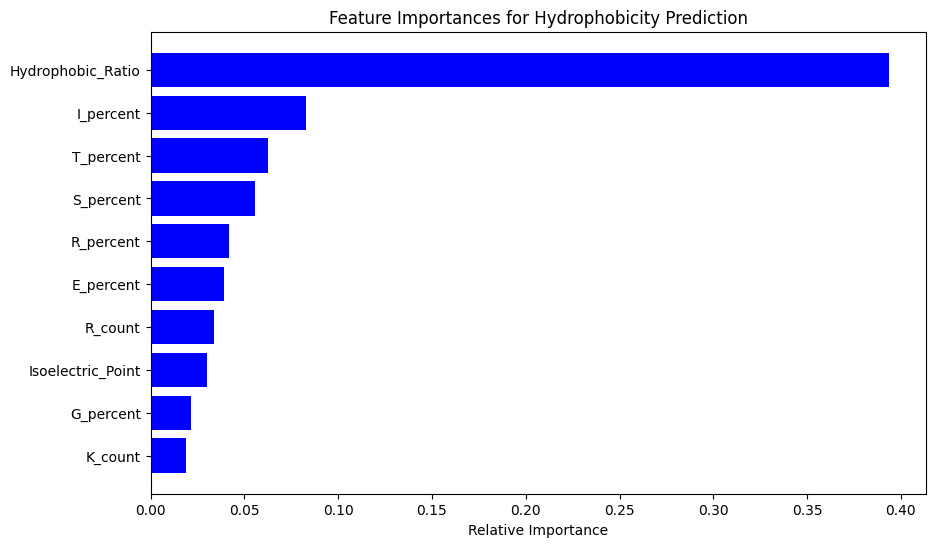

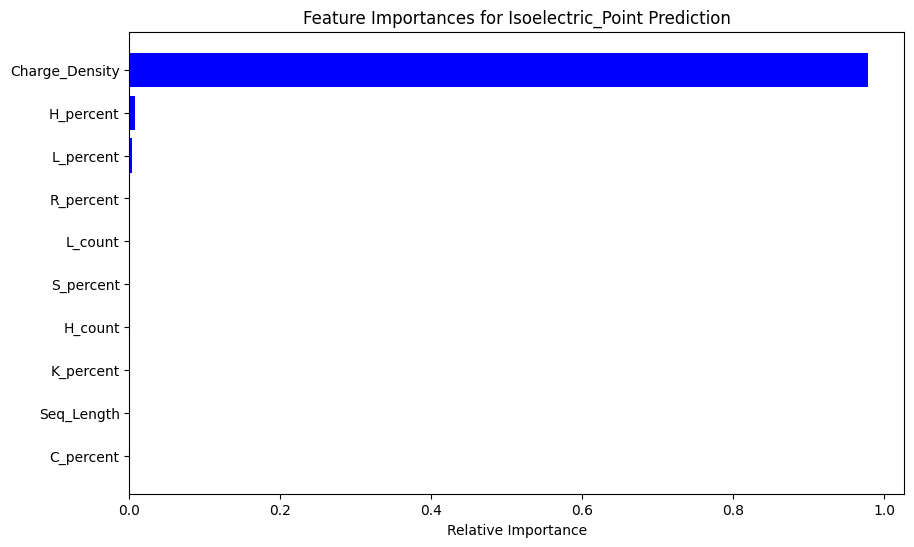

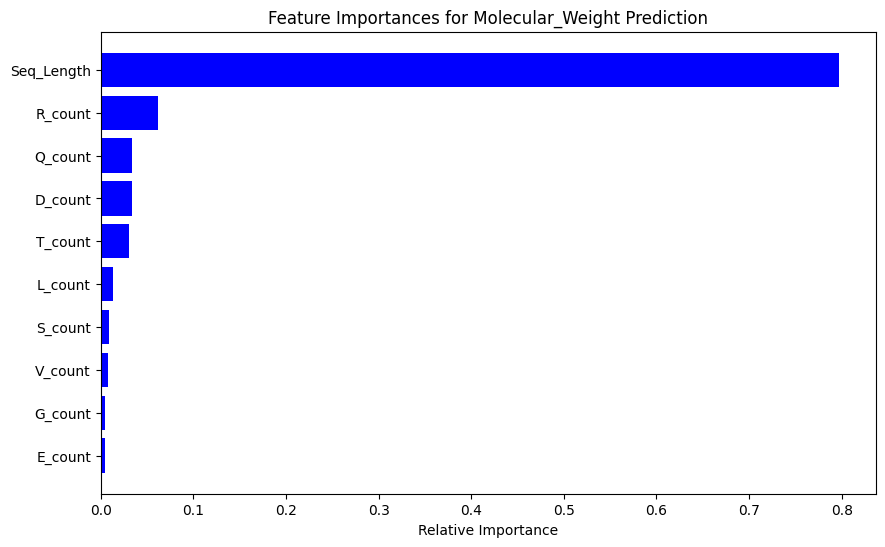

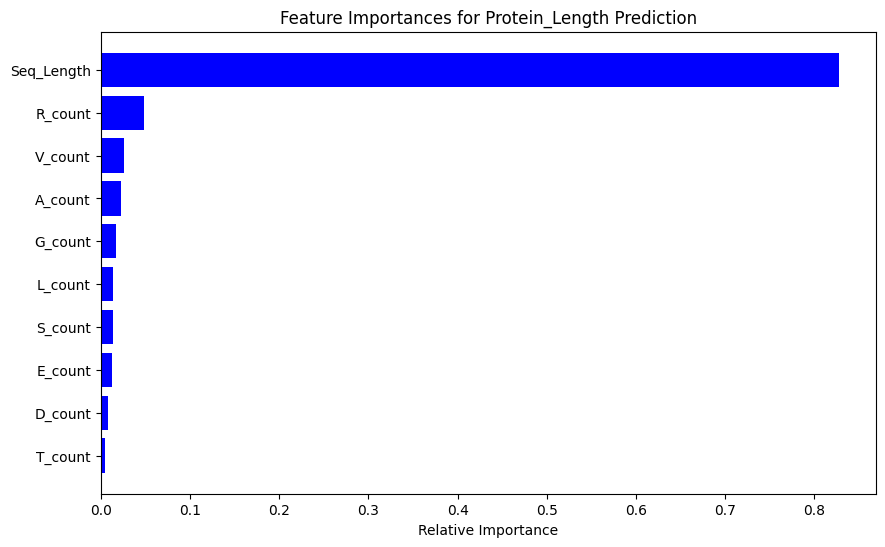

In [10]:
# 5. Prediction Interface
def predict_protein_property(target_name, input_protein_data):
    """Predict any protein property using saved models"""
    try:
        model = joblib.load(f'best_model_{target_name}.pkl')
        scaler = joblib.load(f'scaler_{target_name}.pkl')

        # Create a DataFrame from the input data
        input_df = pd.DataFrame([input_protein_data])

        # Recalculate necessary features if they are not in the input
        amino_acids = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
        for aa in amino_acids:
            if f'{aa}_count' not in input_df.columns and 'Amino_Acid_Composition' in input_df.columns:
                input_df[f'{aa}_count'] = input_df['Amino_Acid_Composition'].apply(lambda x: x.get(aa, 0))
            if f'{aa}_percent' not in input_df.columns and f'{aa}_count' in input_df.columns and 'Seq_Length' in input_df.columns:
                 input_df[f'{aa}_percent'] = input_df[f'{aa}_count'] / input_df['Seq_Length']

        if 'Charge_Density' not in input_df.columns and 'R_count' in input_df.columns and 'K_count' in input_df.columns and 'D_count' in input_df.columns and 'E_count' in input_df.columns and 'Seq_Length' in input_df.columns:
             input_df['Charge_Density'] = (input_df['R_count'] + input_df['K_count'] - input_df['D_count'] - input_df['E_count']) / input_df['Seq_Length']

        if 'Hydrophobic_Ratio' not in input_df.columns and 'A_count' in input_df.columns and 'V_count' in input_df.columns and 'L_count' in input_df.columns and 'I_count' in input_df.columns and 'Seq_Length' in input_df.columns:
             input_df['Hydrophobic_Ratio'] = (input_df['A_count'] + input_df['V_count'] + input_df['L_count'] + input_df['I_count']) / input_df['Seq_Length']


        # Select only relevant features used during training
        feature_names = results[target_name]['features']
        input_df = input_df[feature_names]


        # Scale features
        scaled_input = scaler.transform(input_df)

        # Predict
        prediction = model.predict(scaled_input)

        if results[target_name]['type'] == 'classification':
            print(f"\nPredicted {target_name}: Class {prediction[0]}")
        else:
            print(f"\nPredicted {target_name}: {prediction[0]:.4f}")

        return prediction[0]
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

# Eg Usage
print("\n Example Predictions")
sample_protein = {
    'Seq_Length': 250,
    'Amino_Acid_Composition': {'A': 25, 'L': 20, 'V': 15, 'I': 10, 'R': 5, 'K': 5, 'D': 10, 'E': 10},
    'Hydrophobicity': 0.1, # You might want to predict this based on amino acid composition
    'Isoelectric_Point': 6.5, # You might want to predict this based on amino acid composition
}

for target in target_columns:
    predict_protein_property(target, sample_protein)

# 6. Feature Importance Visualization
for target in target_columns:
    if 'Random Forest' in results[target]['best_model']:
        model = joblib.load(f'best_model_{target}.pkl')
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10 features

        plt.figure(figsize=(10,6))
        plt.title(f'Feature Importances for {target} Prediction')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [results[target]['features'][i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()